# Setups

## Download Projects and Dependencies

In [6]:
!sudo apt install git-lfs
!git clone https://github.com/MMintLab/VIRDO.git

!pip install open3d==0.14.1
!pip install torch==1.10.0+cu111
!pip install plyfile==0.7.4
!python -m pip install git+https://github.com/krrish94/chamferdist.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
fatal: destination path 'VIRDO' already exists and is not an empty directory.
  Cloning https://github.com/krrish94/chamferdist.git to /tmp/pip-req-build-prqxh6o8
  Running command git clone -q https://github.com/krrish94/chamferdist.git /tmp/pip-req-build-prqxh6o8


In [7]:
import os
os.chdir('VIRDO')
!git checkout working
!git pull

M	meta_modules.py
M	modules.py
Already on 'working'
Your branch is up to date with 'origin/working'.
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/MMintLab/VIRDO
   24e0186..2997354  working    -> origin/working
Updating 24e0186..2997354
error: Your local changes to the following files would be overwritten by merge:
	meta_modules.py
	modules.py
Please commit your changes or stash them before you merge.
Aborting


## Download Data/Pretrained models

In [ ]:
os.chdir('data')
!curl https://www.dropbox.com/sh/1q4o86az3sj6xgr/AAD325-PcxYKV7FKAEBI1QoLa?dl=0 -L -O -J
!unzip -o data.zip virdo_simul_dataset.pickle

!curl https://www.dropbox.com/sh/tuu7qsdjgpgimz4/AAB6rUjMohIBDk7aT1Fbyt1ka?dl=0 -L -O -J
!unzip -o pcd_occlusion.zip

os.chdir('../pretrained_model')
!curl https://www.dropbox.com/sh/s1r9gxd9dz4wdkk/AADK6mHvrPtFYo_xD4EmZZdda?dl=0 -L -O -J
!unzip -o pretrained_model.zip
os.chdir('..')

# Load Training Data

In [34]:
import sys, torch, random
from torch.utils.data import DataLoader
from importlib import reload

## Directories
root_path = os.getcwd()
model_directory = os.path.join(root_path, 'pretrained_model')
sys.path.append(root_path)

DEVICE = 'cuda'

In [9]:
import pickle
with open('data/virdo_simul_dataset.pickle', 'rb') as f:
  data_dict = pickle.load(f)

In [10]:
### Pair Object code and Force code
import open3d as o3d
import numpy as np
pairs = {}
data = data_dict['train']
for obj_idx in data: 
    pairs[obj_idx] = []
    for deform_idx in data[obj_idx]:
        if deform_idx != 'nominal':
            pairs[obj_idx].append(deform_idx)
print(pairs)

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 1: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], 2: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], 3: [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], 4: [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119], 5: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]}


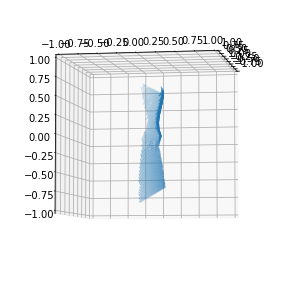

Example of partial pointcloud. Handle and tip are occluded.


In [38]:
from utilities.visualization import *

## Example of partial pointclouds
occ_file_list = ['o0_d9.ply']  #'o0_d9.ply'
occ_data_dict = {}
for f in occ_file_list: 
  obj_idx, def_idx = f.split('.')[0].split('_')
  obj_idx = int(obj_idx[1:])
  def_idx = int(def_idx[1:])

  occ_pcd = torch.tensor(np.array(o3d.io.read_point_cloud('data/'+ f).points)).float()

  occ_data_dict[obj_idx] = {def_idx : {'reaction' : data[obj_idx][def_idx]['reaction'],
                                   'coords': occ_pcd,
                                   'coords_gt': data[obj_idx][def_idx]['coords'],
                                   'sdf_gt': data[obj_idx][def_idx]['gt']}}
  pcd_3d_vis(occ_pcd)

print("Example of partial pointcloud. Handle and tip are occluded.")

# Reconstruction

In [42]:
import modules, diff_operators, meta_modules

## Load logs 
log_idx = 'final' 
force_module_log = torch.load(os.path.join(model_directory, f'force_{log_idx}.pth'),map_location=torch.device('cpu'))
object_module_log = torch.load(os.path.join(model_directory,f'shape_{log_idx}.pth'),map_location=torch.device('cpu'))
deform_module_log = torch.load(os.path.join(model_directory,f'deform_{log_idx}.pth'), map_location=torch.device('cpu'))


## Object Codes 
object_code_weight = object_module_log['shape_embedding'] # tensor [object num x object code_size]
object_code = torch.nn.Embedding.from_pretrained(object_code_weight).float().to(DEVICE)
object_code_size = object_code_weight.shape[1]


## Object Module form pretrained
object_module_weight = object_module_log['shape_model']
object_module = meta_modules.virdo_hypernet(in_features= 3, 
                                              out_features= 1,
                                              hyper_in_features = object_code_size,
                                              hl=2)

object_module.load_state_dict(object_module_weight)
object_module.to(DEVICE )
object_module.eval()


## Deformation Codes & Contact Features
feats = force_module_log['feats']
force_code_weight = feats['f_emb']
cnt_ft = feats['cnt_ft']
deformation_code_size = force_code_weight[0][0].size()[1]
contact_emb_size =  cnt_ft[0][0].size()[1]


## Deformation Module form pretrained
deformation_module_weight = deform_module_log['deform_model']
deformation_module = meta_modules.virdo_hypernet(in_features= 3, out_features= 3, 
                                                   hyper_in_features = deformation_code_size + object_code_size,
                                                   hl=1)

deformation_module.load_state_dict(deformation_module_weight)
deformation_module.to(DEVICE )
deformation_module


classifier_model = modules.PointNetCls(d_cnt_code = contact_emb_size, d_force_emb = deformation_code_size).to(DEVICE)
classifier_model.load_state_dict(force_module_log['force_model'])


<All keys matched successfully>

# Fig8: Inferene

In [43]:
import loss_functions
loss_sdf = loss_functions.hyper_loss
loss_emb =  loss_functions.latent_loss


In [44]:
class Deform_Decoder(torch.nn.Module):
    def __init__(self,shape_model, deform_model, shape_embedding, deform_embedding, device):
        super().__init__()
        self.device = device
        self.shape_embedding = shape_embedding.to(device)
        self.deform_embedding = deform_embedding.to(device)
        self.shape_model = shape_model.to(device)
        self.deform_model = deform_model.to(device)

    def forward(self, coords, type = 'deformed'):
  
        deform_input={'coords':coords, 
                      'embedding':torch.cat([self.deform_embedding,self.shape_embedding],dim=-1)}
        deform_output = self.deform_model(deform_input)

        shape_input = {'coords': deform_output['model_in'].to(self.device),
                    'model_out' :deform_output['model_in'].to(self.device) + deform_output['model_out'],
                    'embedding' : self.shape_embedding}
        
        pred_sdf = self.shape_model(shape_input)
        return pred_sdf
    
    

sampling takes: 11.003599


/content/VIRDO/sdf_meshing.py:115: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3


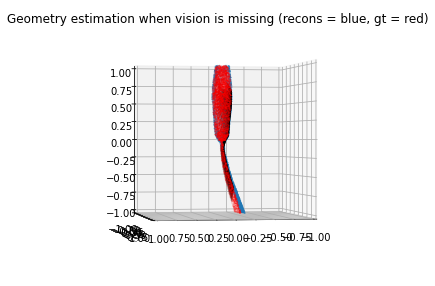

Epoch 0, train loss 0.007749
Epoch 10, train loss 0.001826
Epoch 20, train loss 0.000349
Epoch 30, train loss 0.000337
Epoch 40, train loss 0.000338
Epoch 50, train loss 0.000333
sampling takes: 10.841752


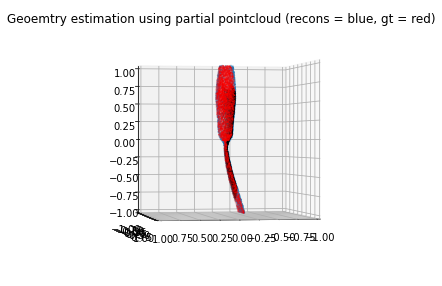

Time required for Inference : 0.7800962924957275 [s]


In [45]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sdf_meshing
from torch import nn
num_epochs = 60
n = 5600


# For each Obj
for obj_idx_, obsv in occ_data_dict.items():
  obj_idx = torch.tensor(obj_idx_).to(DEVICE)
  obj_code_i = object_code(obj_idx).squeeze()

  # For each Observation
  for def_idx_, data_i in obsv.items():

    # Initialize Contact Embedding
    cont_emb_inf_ = torch.nn.Embedding(1, contact_emb_size).requires_grad_(True).to(DEVICE)
    torch.nn.init.normal_(cont_emb_inf_.weight, mean=0.0, std=0.01)
    optims = torch.optim.Adam([{'params': cont_emb_inf_.parameters(), 'lr': 3e-2}])
    cont_emb_inf = cont_emb_inf_.weight

    # Minimize Mismatch between reconstruction vs Partial Observation
    for epoch in range(num_epochs):
      reaction_force = data_i['reaction'].to(DEVICE)

      feat = classifier_model.forward_infer(cont_emb_inf, reaction_force).squeeze()
      ddecoder = Deform_Decoder(object_module, deformation_module, obj_code_i, feat, DEVICE)
      ddcoder_out = ddecoder(data_i['coords'].to(DEVICE))

      coords =ddcoder_out['model_in'].float()
      pred_sdf = ddcoder_out['model_out'].float()

      ## Using only the onsurface points
      loss_inf = torch.abs(pred_sdf).mean() 


      # visualize
      if epoch == 0 or epoch == num_epochs -1:
        source_cloud = source_cloud = sdf_meshing.create_mesh(ddecoder, filename=None, N= 300, 
                                                              output_return = True, 
                                                              verbose = False)
        
        # Random Select pointclouds to have the length
        iidx = np.random.permutation(source_cloud.shape[0])[:n]
        source_cloud = source_cloud[iidx,:]
        source_cloud = torch.tensor(source_cloud).unsqueeze(0).float()
        

        
        ## Visualization 
        target_cloud = data_i['coords_gt'][:,np.where(data_i['sdf_gt']==0)[1],:].detach()
        iidx = np.random.permutation(target_cloud.size()[1])[:n]
        target_cloud = target_cloud[:,iidx,:]

        plt.figure(figsize=(5,5))
        ax = plt.axes(projection='3d')
        ax.axis("on")
        plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

        ax.scatter(source_cloud[:,:,0],source_cloud[:,:,1],source_cloud[:,:,2], s=0.04)
        ax.scatter(target_cloud[:,:,0],target_cloud[:,:,1],target_cloud[:,:,2], s=0.03, c='red')
        ax.scatter(data_i['coords'][:,0],data_i['coords'][:,1],data_i['coords'][:,2], s=0.03, c='black')

        ax.set_xlim3d(-1,1)
        ax.set_ylim3d(-1,1)
        ax.set_zlim3d(-1,1)
        ax.grid()
        ax.view_init(0, 80)

        if epoch == 0 :
          plt.title("Geometry estimation when vision is missing (recons = blue, gt = red)")
        
        if epoch == num_epochs -1:
           plt.title(f'Geoemtry estimation using partial pointcloud (recons = blue, gt = red)')
        
        plt.show()
 

      # Update
      optims.zero_grad()
      loss_inf.backward()
      optims.step()

      if not epoch % 10:
          tqdm.write("Epoch %d, train loss %0.6f" % (epoch, loss_inf))
      
      # Measure time
      if epoch == 1:
        start = time.time()
      if epoch == num_epochs -2:
        end = time.time()

    print("Time required for Inference :", end - start, "[s]")